# DeepLabCut Speed Calculation

A Jupyter notebook to load DeepLabCut CSV output and calculate mouse speed based on tracked body parts.

## Setup Environment and Variables

Import necessary libraries (pandas, numpy). Define variables for the input directory (`input_dir`), DLC output filename (`file_name`), desired likelihood threshold (`likelihood_threshold`), and video frame rate (`frame_rate` in frames per second).

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import linregress
%matplotlib widget
%load_ext autoreload
%autoreload 2
from plotting_utils import *
from debugging_functions import *


# --- User Defined Variables ---

# Directory containing the DLC output CSV file
input_dir = r'C:\Users\Experiment\Projects\video_conversions\full'

# Name of the DLC CSV file (output from DLC analysis)
file_name = 'fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv' 

video_filename = file_name.split('DLC_resnet')[0] + 'DLC_resnet50_downsampled_trialJul11shuffle1_150000_labeled.mp4'
# Likelihood threshold - points below this threshold will be considered unreliable
likelihood_threshold = 0.95

# Frame rate of the video in frames per second (FPS)
frame_rate = 60

DEFAULT_BODYPARTS = [
    'neck', 'mid_back', 'mouse_center', 'mid_backend', 'left_midside', 
    'right_midside', 'right_hip', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip',
    'left_shoulder', 'right_shoulder', 'head_midpoint'
]
# Body parts to use for speed calculation.
# Provide a list of bodypart names, e.g., ['nose', 'mouse_center', 'tail_base'].
# If the list is empty or None, all bodyparts found in the file will be used.
bodyparts_for_calculation = [] # 'mouse_center', 'mid_back', 'neck'


# Construct the full file path
file_path = os.path.join(input_dir, file_name)

video_file_path = os.path.join(input_dir, video_filename)
if not os.path.exists(video_file_path):
    print(f"Warning: Video file not found at {video_file_path}. Video generation will be skipped.")
    create_synced_video = False
else:
    create_synced_video = True # Set to False to skip video generation
    print(f"Video file found: {video_file_path}")

print(f"Input Directory: {input_dir}")
print(f"File Name: {file_name}")
print(f"Full File Path: {file_path}")
print(f"Likelihood Threshold: {likelihood_threshold}")
print(f"Frame Rate (FPS): {frame_rate}")
print(f"Bodyparts for Speed Calculation: {'Default List' if not bodyparts_for_calculation else ('All' if bodyparts_for_calculation == ['all'] else bodyparts_for_calculation)}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Video file found: C:\Users\Experiment\Projects\video_conversions\full\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_labeled.mp4
Input Directory: C:\Users\Experiment\Projects\video_conversions\full
File Name: fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Full File Path: C:\Users\Experiment\Projects\video_conversions\full\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000.csv
Likelihood Threshold: 0.95
Frame Rate (FPS): 60
Bodyparts for Speed Calculation: Default List


## Load DLC Data

Read the specified CSV file using pandas. Handle the multi-level header correctly (scorer, bodyparts, coords) by specifying the header rows. Display the first few rows and the structure (columns) of the loaded DataFrame.

In [3]:
# Check if the file exists before attempting to load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: The file was not found at the specified path: {file_path}")

# Load the CSV file, specifying the header rows
# DLC CSV files typically have a multi-level header:
# Row 0: Scorer
# Row 1: Bodyparts
# Row 2: Coordinates (x, y, likelihood)
try:
    df_dlc = pd.read_csv(file_path, header=[1, 2], index_col=0)
    print("DLC data loaded successfully.")
except Exception as e:
    print(f"Error loading CSV file: {e}")
    raise

# Display the first few rows
print("\nFirst 5 rows of the loaded data:")
print(df_dlc.head())

# Display the column structure (multi-index)
print("\nDataFrame Columns:")
print(df_dlc.columns)

# Display basic info
print("\nDataFrame Info:")
df_dlc.info()

DLC data loaded successfully.

First 5 rows of the loaded data:
bodyparts        nose              ... head_midpoint           
coords              x           y  ...             y likelihood
0          129.560760  402.219238  ...    416.166321   0.999988
1          129.439468  402.191986  ...    416.067688   0.999989
2          128.443726  402.066254  ...    416.369629   0.999985
3          180.338257  461.936218  ...    416.621002   0.999978
4          128.178284  402.274353  ...    416.569946   0.999987

[5 rows x 81 columns]

DataFrame Columns:
MultiIndex([(          'nose',          'x'),
            (          'nose',          'y'),
            (          'nose', 'likelihood'),
            (      'left_ear',          'x'),
            (      'left_ear',          'y'),
            (      'left_ear', 'likelihood'),
            (     'right_ear',          'x'),
            (     'right_ear',          'y'),
            (     'right_ear', 'likelihood'),
            (  'left_ear_tip', 

## Define Speed Calculation Strategy

Describe the chosen strategy for speed calculation.

**Chosen Strategy (Median-Based):**
1.  Identify the body parts to use for calculation based on the `bodyparts_for_calculation` list. If the list is empty, use the `DEFAULT_BODYPARTS`. If `['all']` is specified, use all available body parts.
2.  For each frame:

    a.  Filter the coordinates (x, y) of each selected body part: if the likelihood for that body part in that frame is below `likelihood_threshold`, its coordinates for that frame are considered NaN.
    
    b.  Calculate the **median x-coordinate** and **median y-coordinate** from all *valid* (non-NaN) selected body parts for that frame. This defines a single "median point" for the animal. If too few parts are valid to calculate a median (e.g., all are NaN), the median point's coordinates will be NaN.
3.  Calculate the frame-to-frame displacement (Euclidean distance) of this "median point".
4.  Convert this displacement (pixels/frame) into speed (pixels/second) using the `frame_rate`.
5.  The speed for the very first frame will be NaN. Speed will also be NaN for transitions where the median point in either the current or preceding frame could not be determined (was NaN).

## Select and Filter Tracking Points

Select the x, y, and likelihood columns for the body part(s) chosen in the strategy. Apply the `likelihood_threshold`: set x, y coordinates to NaN for frames where the likelihood of the chosen point(s) is below the threshold.

In [4]:
all_bodyparts = df_dlc.columns.get_level_values(0).unique().tolist()
print(f"\nAvailable bodyparts in file: {all_bodyparts}")

final_bodyparts_list = []
missing_parts = []
calculation_mode = None # To store how the list was derived ('all', 'default', 'custom')

if bodyparts_for_calculation == ['all']:
    final_bodyparts_list = all_bodyparts
    calculation_mode = 'all'
    print("\nUsing all available bodyparts for calculation.")
elif not bodyparts_for_calculation: # Empty list means use default
    requested_parts = DEFAULT_BODYPARTS
    calculation_mode = 'default'
    print(f"\nAttempting to use Default bodyparts list: {requested_parts}")
    # Validate default parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Default bodyparts were not found in the file and will be ignored: {missing_parts}")
else: # Custom list provided
    requested_parts = bodyparts_for_calculation
    calculation_mode = 'custom'
    print(f"\nAttempting to use Custom bodyparts list: {requested_parts}")
    # Validate custom parts against available parts
    for bp in requested_parts:
        if bp in all_bodyparts:
            final_bodyparts_list.append(bp)
        else:
            missing_parts.append(bp)
    if missing_parts:
        print(f"Warning: The following Custom bodyparts were not found in the file and will be ignored: {missing_parts}")

# Final check and report
if not final_bodyparts_list:
    raise ValueError("Error: No valid bodyparts selected for calculation based on input and file contents.")

print(f"\nFinal list of bodyparts used for calculation ({calculation_mode} mode): {final_bodyparts_list}")



Available bodyparts in file: ['nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder', 'left_midside', 'left_hip', 'right_shoulder', 'right_midside', 'right_hip', 'tail_end', 'head_midpoint']

Attempting to use Default bodyparts list: ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'left_midside', 'right_midside', 'right_hip', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_shoulder', 'right_shoulder', 'head_midpoint']

Final list of bodyparts used for calculation (default mode): ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'left_midside', 'right_midside', 'right_hip', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_shoulder', 'right_shoulder', 'head_midpoint']


## Calculate Frame-by-Frame Displacement

Calculate the difference in x and y coordinates between consecutive frames for the filtered tracking point(s). Use the Euclidean distance formula: `sqrt(delta_x^2 + delta_y^2)` to find the displacement in pixels per frame. Handle potential NaN values introduced by filtering or inherent in the data.

In [5]:
# --- Calculate Displacement Per Bodypart with Likelihood Check & Interpolation ---
df_dlc[('analysis', 'median_x')] = np.nan
df_dlc[('analysis', 'median_y')] = np.nan

# Store filtered and interpolated coordinates temporarily to calculate medians
filtered_x_coords = pd.DataFrame(index=df_dlc.index)
filtered_y_coords = pd.DataFrame(index=df_dlc.index)

MAX_CONSECUTIVE_NAN_INTERPOLATE = 60 # Define the number of consecutive frames that can be NaN and still be interpolated

print(f"\nApplying likelihood filter and conditional interpolation (max_gap={MAX_CONSECUTIVE_NAN_INTERPOLATE} frames) to selected bodyparts...")
for bp in final_bodyparts_list:
    if (bp, 'x') not in df_dlc.columns or \
       (bp, 'y') not in df_dlc.columns or \
       (bp, 'likelihood') not in df_dlc.columns:
        print(f"Warning: Data for bodypart {bp} (x, y, or likelihood) not found. Skipping.")
        filtered_x_coords[bp] = np.nan # Fill with NaNs to maintain DataFrame structure
        filtered_y_coords[bp] = np.nan
        continue

    x = df_dlc[(bp, 'x')].copy() # Use .copy() to avoid SettingWithCopyWarning
    y = df_dlc[(bp, 'y')].copy()
    likelihood = df_dlc[(bp, 'likelihood')]
    
    # Apply likelihood threshold: set x, y to NaN where likelihood is low
    mask = likelihood < likelihood_threshold
    x[mask] = np.nan
    y[mask] = np.nan
    
    # Apply conditional interpolation
    x_processed = interpolate_gaps_conditionally(x, MAX_CONSECUTIVE_NAN_INTERPOLATE)
    y_processed = interpolate_gaps_conditionally(y, MAX_CONSECUTIVE_NAN_INTERPOLATE)
    
    filtered_x_coords[bp] = x_processed
    filtered_y_coords[bp] = y_processed

print("\nCalculating median X and Y coordinates per frame from processed data...")
# Calculate median across the filtered and interpolated coordinates for each frame (row-wise)
df_dlc[('analysis', 'median_x')] = filtered_x_coords.median(axis=1, skipna=True)
df_dlc[('analysis', 'median_y')] = filtered_y_coords.median(axis=1, skipna=True)

print("Median coordinates calculated. First 5 rows of median:")
print(df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]].head())

# --- Calculate Displacement of the Median Point ---
print("\nCalculating displacement of the (potentially interpolated) median point...")
median_x_coords = df_dlc[('analysis', 'median_x')]
median_y_coords = df_dlc[('analysis', 'median_y')]

# Calculate difference between consecutive frames for the median point
delta_median_x = median_x_coords.diff()
delta_median_y = median_y_coords.diff()

# Calculate Euclidean distance for the median point's displacement
# NaNs will propagate if median_x/y was NaN or if the previous frame's median_x/y was NaN
displacement_median_pixels = np.sqrt(delta_median_x**2 + delta_median_y**2)

# Store the displacement of the median point
df_dlc[('analysis', 'displacement_median_pixels')] = displacement_median_pixels

print("Displacement of median point calculated. First 5 rows of displacement:")
print(df_dlc[('analysis', 'displacement_median_pixels')].head())

print("\nNaN counts for processed median coordinates and their displacement:")
print(f"Median X NaNs: {df_dlc[('analysis', 'median_x')].isna().sum()}")
print(f"Median Y NaNs: {df_dlc[('analysis', 'median_y')].isna().sum()}")
print(f"Displacement of Median NaNs: {df_dlc[('analysis', 'displacement_median_pixels')].isna().sum()}")


Applying likelihood filter and conditional interpolation (max_gap=60 frames) to selected bodyparts...

Calculating median X and Y coordinates per frame from processed data...
Median coordinates calculated. First 5 rows of median:
bodyparts    analysis            
coords       median_x    median_y
0          142.427238  432.554749
1          142.349670  432.284225
2          142.591110  430.954773
3          142.695908  431.192993
4          142.980728  431.182755

Calculating displacement of the (potentially interpolated) median point...
Displacement of median point calculated. First 5 rows of displacement:
0         NaN
1    0.281424
2    1.351198
3    0.260252
4    0.285005
Name: (analysis, displacement_median_pixels), dtype: float64

NaN counts for processed median coordinates and their displacement:
Median X NaNs: 0
Median Y NaNs: 0
Displacement of Median NaNs: 1


## Calculate Speed

Convert the displacement (pixels/frame) into speed (e.g., pixels/second). Use the `frame_rate` variable.

Speed = Displacement / Time per Frame
Time per Frame = 1 / `frame_rate`
Speed = Displacement / (1 / `frame_rate`) = Displacement * `frame_rate`

Store the calculated speed in a new column in the DataFrame. Handle the first frame (which has no preceding frame for displacement calculation) and frames where displacement is NaN.

In [6]:
create_plots = True # Set to False to skip plotting
plot_individual_parts = True # Set to False to plot only average speed
save_plots = True
smoothing_window_seconds = 15/60 # Smoothing window in s. Set to 0 for no smoothing.


Main DataFrame with Median-Derived Speed columns added:
bodyparts    analysis  ...                        
coords       median_x  ... speed_pixels_per_second
0          142.427238  ...                     NaN
1          142.349670  ...               16.885447
2          142.591110  ...               81.071905
3          142.695908  ...               15.615149
4          142.980728  ...               17.100272

[5 rows x 4 columns]

Speed Summary Statistics (pixels/second) - Median Based:
count    144499.000000
mean         27.264688
std          41.363934
min           0.027890
25%           5.840574
50%          12.430614
75%          32.637818
max        1629.878479
Name: (analysis, speed_pixels_per_second), dtype: float64

Ensured output directory exists: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation
DataFrame with median-derived speed saved to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuff

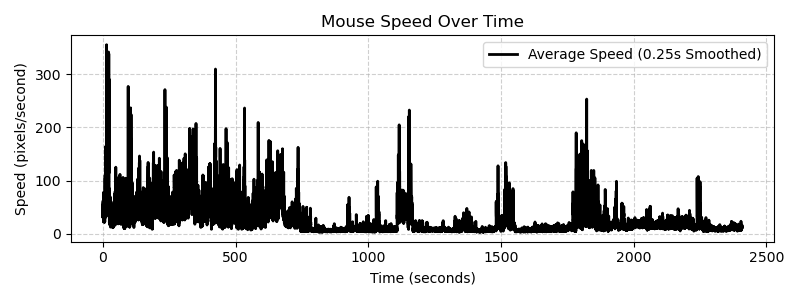

In [7]:
# --- Calculate Average Displacement and Speed ---

time_per_frame = 1.0 / frame_rate # seconds per frame

# Calculate speed in pixels per second
# Speed = Displacement of Median Point (pixels/frame) * Frame Rate (frames/second)
speed_pixels_per_second = df_dlc[('analysis', 'displacement_median_pixels')] * frame_rate

# --- Add results to the main DataFrame ---
# Remove the old 'average_displacement_pixels' column if it exists to avoid confusion
if ('analysis', 'average_displacement_pixels') in df_dlc.columns:
    df_dlc = df_dlc.drop(columns=[('analysis', 'average_displacement_pixels')])

df_dlc[('analysis', 'speed_pixels_per_second')] = speed_pixels_per_second

# Sort columns for potentially better readability (optional)
df_dlc = df_dlc.sort_index(axis=1)

print("\nMain DataFrame with Median-Derived Speed columns added:")
# Display head focusing on new columns
if all(col in df_dlc.columns for col in [('analysis', 'median_x'), ('analysis', 'median_y'), ('analysis', 'displacement_median_pixels'), ('analysis', 'speed_pixels_per_second')]):
    print(df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y'), ('analysis', 'displacement_median_pixels'), ('analysis', 'speed_pixels_per_second')]].head())
else:
    print(df_dlc.head())


# Display summary statistics for the calculated speed
print("\nSpeed Summary Statistics (pixels/second) - Median Based:")
# Check if the speed column exists before describing
if ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print(df_dlc[('analysis', 'speed_pixels_per_second')].describe())
else:
    print("Speed column ('analysis', 'speed_pixels_per_second') not found.")

# --- Save the DataFrame with the speed column ---

# Define the subdirectory name
output_subdir = "speed_calculation"
# Create the full path for the output directory
output_dir_path = os.path.join(input_dir, output_subdir)

# Create the subdirectory if it doesn't exist
os.makedirs(output_dir_path, exist_ok=True)
print(f"\nEnsured output directory exists: {output_dir_path}")

base_name_without_ext = os.path.splitext(file_name)[0]
# Add '_all' suffix if the initial bodyparts_for_calculation list was empty
if calculation_mode == 'all':
    suffix = '_all_avg_speed'
elif calculation_mode == 'default':
    suffix = '_default_avg_speed'
elif calculation_mode == 'custom':
    if not final_bodyparts_list: # Should not happen due to check above, but safe
         print("Warning: Custom mode selected but final_bodyparts_list is empty.")
    elif len(final_bodyparts_list) == 1:
        parts_suffix = final_bodyparts_list[0]
        suffix = f'_{parts_suffix}_avg_speed'
    elif len(final_bodyparts_list) == 2:
        parts_suffix = '_'.join(final_bodyparts_list)
        suffix = f'_{parts_suffix}_avg_speed'
    else: # 3 or more parts
        parts_suffix = '_'.join(final_bodyparts_list[:2]) + '_etc'
        suffix = f'_{parts_suffix}_avg_speed'
else:
     print(f"Warning: Unknown calculation_mode '{calculation_mode}'. Using fallback suffix.")
# --- End suffix generation ---

base_output_name = base_name_without_ext + suffix
output_filename_csv = os.path.join(output_dir_path, base_output_name + '.csv')


# Save the DataFrame
try:
    df_dlc.to_csv(output_filename_csv)
    print(f"DataFrame with median-derived speed saved to: {output_filename_csv}")
except Exception as e:
    print(f"Error saving CSV file: {e}")

if create_plots:
    # Since df_displacements (for individual parts) is no longer calculated in the previous cell,
    # we pass an empty DataFrame for it. The plot_speed function's 'Average Speed'
    # will use the new median-derived speed_pixels_per_second from df_dlc.
    # Set plot_individual=False as individual part displacements are not available here.
    empty_df_displacements = pd.DataFrame(index=df_dlc.index)

    plot_speed(df_dlc=df_dlc,
               df_displacements=empty_df_displacements, # Pass empty df
               final_bodyparts_list=final_bodyparts_list, # Still useful for context
               frame_rate=frame_rate,
               output_dir=output_dir_path,
               base_filename=base_output_name,
               plot_individual=False, # Set to False as individual displacements are not passed
               save_plot=save_plots,
               smoothing_window_seconds=smoothing_window_seconds)
else:
    print("\nPlotting is disabled (create_plots=False).")

## Create Video with running graph underneath

Note: this is without the sleep data, for that, see below


In [ ]:
# --- Cell for Creating Synchronized Video ---

# Only run if video file was found and create_synced_video is True
if create_synced_video and 'df_dlc' in locals() and ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print("\n--- Starting Synchronized Video Generation ---")

   

    # Define output video path
    video_output_filename = base_output_name + '_synced_video.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # --- Prepare Smoothed Speed Data ---
    # Calculate smoothing window in frames
    if smoothing_window_seconds > 0:
        smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
        if smoothing_window_frames < 1:
            smoothing_window_frames = 1
        print(f"Calculating smoothed speed with window: {smoothing_window_frames} frames ({smoothing_window_seconds}s)")
        # Use rolling average on the speed column
        # center=False aligns the window to the right (causal smoothing)
        # min_periods=1 ensures output even at the beginning
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(window=smoothing_window_frames, min_periods=1, center=False).mean()
    else:
        # ...
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]
        # ...

    # --- Prepare Median Coordinates for Overlay ---
    median_coords_for_video = None
    if ('analysis', 'median_x') in df_dlc.columns and \
       ('analysis', 'median_y') in df_dlc.columns:
        median_coords_for_video = df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]]
    else:
        print("Warning: Median coordinate columns not found in df_dlc. Median point overlay will be skipped.")


    # Call the video creation function
    create_synced_video_with_plot(
        video_path=video_file_path,
        speed_data=smoothed_speed,
        frame_rate=frame_rate,
        output_video_path=output_video_path,
        median_coords=df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]], # Pass the median coordinates
        plot_width_seconds=5.0,
        plot_height_pixels=200,
        median_point_radius=5, 
        median_point_color=(255,0,0) 
    )
  
elif not create_synced_video:
    print("\nSkipping synchronized video generation because 'create_synced_video' is False or video file was not found.")
else:
    print("\nSkipping synchronized video generation: Prerequisite data ('df_dlc' or speed column) not available.")


## Sleep Phase Analysis

This section aims to identify periods where the animal is likely sleeping based on sustained low movement. We will then analyze these sleep bouts for changes in arousal.

**Approach for Identifying Sleep Bouts:**
1.  Define a **speed threshold** below which the animal is considered to be in a low-activity state.
2.  Define a **minimum duration** for which this low-activity state must be maintained to be classified as a sleep bout.
3.  Apply these criteria to the smoothed speed data to identify the start and end times of each sleep bout.

In [8]:
sleep_speed_threshold_pixels_per_second = 60.0  
min_sleep_duration_seconds = 10
if 'smoothed_speed' not in globals():
    # Fallback: Recalculate smoothed_speed if not found (e.g., if video cell was skipped)
    print("Warning: 'smoothed_speed' not found. Recalculating based on 'smoothing_window_seconds'...")
    if smoothing_window_seconds > 0:
        smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
        if smoothing_window_frames < 1: smoothing_window_frames = 1
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(
            window=smoothing_window_frames, min_periods=1, center=False
        ).mean()
        print(f"Recalculated smoothed speed with window: {smoothing_window_frames} frames.")
    else:
        smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]
        print("Using unsmoothed speed as smoothing_window_seconds is 0.")
else:
    print("'smoothed_speed' data found and will be used for sleep analysis.")


Recalculated smoothed speed with window: 15 frames.



Identified 17 sleep bout(s) meeting the criteria:
    start_time_s   end_time_s  duration_s  avg_speed_in_bout  max_speed_in_bout
0      27.750000    42.933333   15.183333          25.101659          59.337020
1     362.383333   376.750000   14.366667          33.007027          59.879809
2     535.833333   547.850000   12.016667          27.219687          59.425757
3     548.016667   563.283333   15.266667          25.339116          56.246084
4     682.833333   727.366667   44.533333          26.330362          59.950724
5     738.166667   927.666667  189.500000           9.459821          59.957843
6     927.750000  1030.033333  102.283333           9.721294          57.786466
7    1037.866667  1108.833333   70.966667           8.862376          56.199450
8    1163.983333  1482.333333  318.350000           8.931735          58.639812
9    1490.783333  1514.566667   23.783333          16.834440          56.100810
10   1532.250000  1545.116667   12.866667          22.262498         

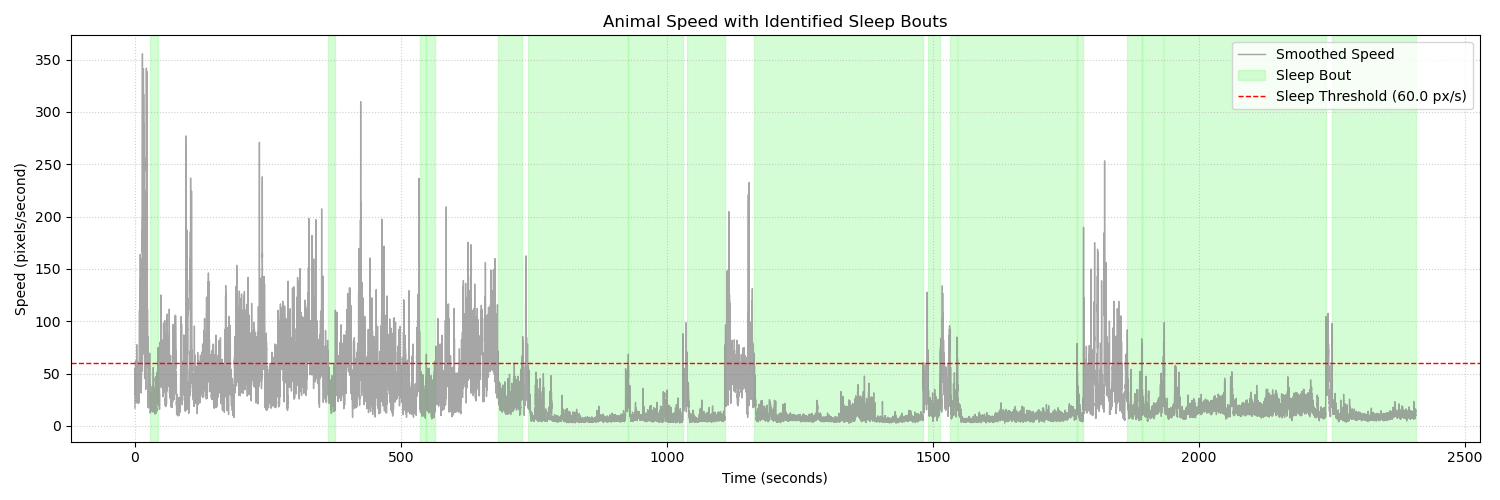

In [9]:
is_low_activity = smoothed_speed < sleep_speed_threshold_pixels_per_second

# 2. Identify contiguous blocks of low activity
#    A change from False to True is a start, True to False is an end.
#    We can find groups of consecutive True/False values.
activity_groups = is_low_activity.ne(is_low_activity.shift()).cumsum()
low_activity_periods = is_low_activity[is_low_activity] # Filter for only True (low activity) periods

sleep_bouts = []
if not low_activity_periods.empty:
    for group_id, group_data in low_activity_periods.groupby(activity_groups[is_low_activity]):
        start_frame = group_data.index[0]
        end_frame = group_data.index[-1]
        
        # Calculate duration in frames and seconds
        duration_frames = (end_frame - start_frame) + 1 # Inclusive
        duration_seconds = duration_frames / frame_rate
        
        if duration_seconds >= min_sleep_duration_seconds:
            start_time_seconds = start_frame / frame_rate
            end_time_seconds = (end_frame + 1) / frame_rate # End time is exclusive for slicing later
            
            sleep_bouts.append({
                'start_frame': start_frame,
                'end_frame': end_frame,
                'start_time_s': start_time_seconds,
                'end_time_s': end_time_seconds,
                'duration_s': duration_seconds,
                'avg_speed_in_bout': smoothed_speed.loc[start_frame:end_frame].mean(),
                'max_speed_in_bout': smoothed_speed.loc[start_frame:end_frame].max()
            })

df_sleep_bouts = pd.DataFrame(sleep_bouts)

if not df_sleep_bouts.empty:
    print(f"\nIdentified {len(df_sleep_bouts)} sleep bout(s) meeting the criteria:")
    print(df_sleep_bouts[['start_time_s', 'end_time_s', 'duration_s', 'avg_speed_in_bout', 'max_speed_in_bout']].to_string())
else:
    print("\nNo sleep bouts identified meeting the specified criteria.")
    print("Consider adjusting 'sleep_speed_threshold_pixels_per_second' or 'min_sleep_duration_seconds'.")

if create_plots and not df_sleep_bouts.empty:
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Plot the smoothed speed
    time_axis_seconds = smoothed_speed.index / frame_rate
    ax.plot(time_axis_seconds, smoothed_speed, label='Smoothed Speed', color='grey', alpha=0.7, lw=1)
    
    # Plot the raw speed for comparison (can be noisy)
    # raw_speed_time_axis = df_dlc.index / frame_rate
    # ax.plot(raw_speed_time_axis, df_dlc[('analysis', 'speed_pixels_per_second')], label='Raw Speed', color='lightblue', alpha=0.5, lw=0.5)

    # Highlight sleep bouts
    for _, bout in df_sleep_bouts.iterrows():
        ax.axvspan(bout['start_time_s'], bout['end_time_s'], color='palegreen', alpha=0.4, label='Sleep Bout' if _ == 0 else "") # Label only once

    ax.axhline(sleep_speed_threshold_pixels_per_second, color='r', linestyle='--', lw=1, label=f'Sleep Threshold ({sleep_speed_threshold_pixels_per_second} px/s)')
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Speed (pixels/second)")
    ax.set_title("Animal Speed with Identified Sleep Bouts")
    
    # Improve legend uniqueness
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    if save_plots:
        plot_filename = os.path.join(output_dir_path, base_output_name + '_sleep_bouts.png')
        try:
            plt.savefig(plot_filename, dpi=300)
            print(f"\nSleep bouts plot saved to: {plot_filename}")
        except Exception as e:
            print(f"Error saving sleep bouts plot: {e}")
    
    plt.show()
elif not create_plots:
    print("\nPlotting is disabled (create_plots=False).")
elif df_sleep_bouts.empty and create_plots:
    print("\nNo sleep bouts to plot.")

In [16]:
# --- Cell for Creating Synchronized Video with Sleep Analysis ---

# Set to False to skip video generation
generate_sleep_analysis_video = True  

if generate_sleep_analysis_video and 'df_dlc' in locals() and ('analysis', 'speed_pixels_per_second') in df_dlc.columns:
    print("\n--- Starting Synchronized Video Generation with Sleep Analysis ---")

    # Define output video path for sleep analysis video (different name than the regular synced video)
    video_output_filename = base_output_name + '_sleep_analysis_video.mp4'
    output_video_path = os.path.join(output_dir_path, video_output_filename)

    # Check if smoothed_speed is already calculated
    if 'smoothed_speed' not in locals():
        # Calculate smoothing window in frames
        if smoothing_window_seconds > 0:
            smoothing_window_frames = int(smoothing_window_seconds * frame_rate)
            if smoothing_window_frames < 1:
                smoothing_window_frames = 1
            print(f"Calculating smoothed speed with window: {smoothing_window_frames} frames ({smoothing_window_seconds}s)")
            # Use rolling average on the speed column
            smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')].rolling(window=smoothing_window_frames, min_periods=1, center=False).mean()
        else:
            smoothed_speed = df_dlc[('analysis', 'speed_pixels_per_second')]

    # Check if df_sleep_bouts exists and is not empty
    if 'df_sleep_bouts' not in locals() or df_sleep_bouts.empty:
        print("Warning: No sleep bouts found. The video will not show any sleep periods.")
        sleep_bouts_for_video = pd.DataFrame()
    else:
        sleep_bouts_for_video = df_sleep_bouts
        print(f"Using {len(sleep_bouts_for_video)} identified sleep bouts for visualization.")

    # Call the video creation function with sleep analysis
    try:
        create_synced_video_with_sleep_analysis(
            video_path=video_file_path,
            speed_data=smoothed_speed,
            frame_rate=frame_rate,
            output_video_path=output_video_path,
            df_sleep_bouts=sleep_bouts_for_video,  # Pass the sleep bouts DataFrame
            median_coords=df_dlc[[('analysis', 'median_x'), ('analysis', 'median_y')]],
            plot_width_seconds=5.0,
            plot_height_pixels=200,
            median_point_radius=5,
            median_point_color=(255, 0, 0),  # Red in BGR
            sleep_threshold=sleep_speed_threshold_pixels_per_second,
            arousal_low_threshold=20.0,
            arousal_high_threshold=40.0
        )
        print(f"Sleep analysis video created at: {output_video_path}")
    except Exception as e:
        print(f"Error creating sleep analysis video: {e}")
        import traceback
        traceback.print_exc()

elif not generate_sleep_analysis_video:
    print("\nSkipping sleep analysis video generation (generate_sleep_analysis_video=False)")
else:
    print("\nSkipping sleep analysis video generation: Required data not available.")


--- Starting Synchronized Video Generation with Sleep Analysis ---
Using 17 identified sleep bouts for visualization.
Starting synchronized video creation with sleep analysis: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_sleep_analysis_video.mp4
Original matplotlib backend: module://ipympl.backend_nbagg
Temporarily switched matplotlib backend to: Agg


t:  24%|██▍       | 34641/144500 [43:11<49:40, 36.87it/s, now=None]

Median coordinates provided for overlay.
Added 17 sleep periods for visualization.
Writing final video to C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_sleep_analysis_video.mp4...
Moviepy - Building video C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_sleep_analysis_video.mp4.
Moviepy - Writing video C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_sleep_analysis_video.mp4



t:  24%|██▍       | 34641/144500 [1:45:25<49:40, 36.87it/s, now=None]

Moviepy - Done !
Moviepy - video ready C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_sleep_analysis_video.mp4
Video encoding with h264_nvenc successful.
Video creation with sleep analysis complete.
Restored matplotlib backend to: module://ipympl.backend_nbagg
Sleep analysis video created at: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_sleep_analysis_video.mp4


### Calculate body movement and turning / angle of movement

Calculate body movement: 
The sum of the distances of each bodypart (in the default list) to the median (proxy of body center) at all timepoints divided by the current number of bodyparts.


--- Calculating Body Posture Metric (Average Distance to Median) ---
'('analysis', 'avg_dist_to_median')' column added to df_dlc.

Summary for ('analysis', 'avg_dist_to_median'):
count    144500.000000
mean         16.998107
std           1.419622
min           5.836155
25%          16.117269
50%          17.220403
75%          18.103812
max          21.682542
Name: (analysis, avg_dist_to_median), dtype: float64

--- Plotting Body Posture Metric ---
Body posture metric plot saved to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_body_posture_metric.png


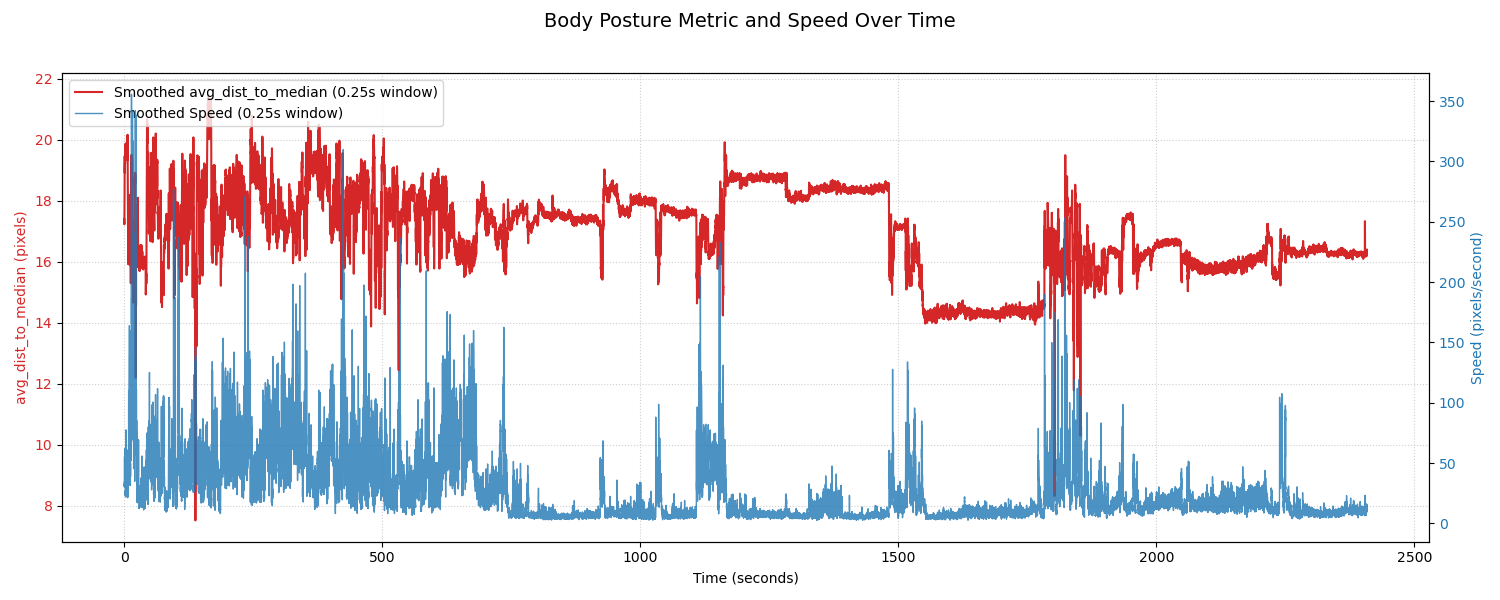

In [10]:
if 'df_dlc' in globals() and ('analysis', 'median_x') in df_dlc.columns and ('analysis', 'median_y') in df_dlc.columns:
    print("\n--- Calculating Body Posture Metric (Average Distance to Median) ---")

    all_processed_x_coords = filtered_x_coords 
    all_processed_y_coords = filtered_y_coords
    
    # --- Step 1: Calculate distance of each processed bodypart to the median point ---
    median_x_series = df_dlc[('analysis', 'median_x')]
    median_y_series = df_dlc[('analysis', 'median_y')]
    
    df_distances_to_median = pd.DataFrame(index=df_dlc.index)

    # Iterate through the bodyparts that were actually processed and are columns in all_processed_x_coords
    for bp in final_bodyparts_list: 
        if bp in all_processed_x_coords.columns and bp in all_processed_y_coords.columns:
            x_bp = all_processed_x_coords[bp]
            y_bp = all_processed_y_coords[bp]
            
            # Distance calculation: sqrt((x_bp - median_x)^2 + (y_bp - median_y)^2)
            # NaNs will propagate correctly (e.g., if median is NaN or bodypart is NaN)
            dist_bp = np.sqrt((x_bp - median_x_series)**2 + (y_bp - median_y_series)**2)
            df_distances_to_median[bp] = dist_bp

    # --- Step 2: Calculate sum of distances and count of valid bodyparts per frame ---
    # Only consider columns that were actually added to df_distances_to_median
    sum_of_distances = df_distances_to_median.sum(axis=1, skipna=True)
    count_of_valid_bodyparts = df_distances_to_median.notna().sum(axis=1)

    # --- Step 3: Calculate average distance to median (handle division by zero) ---
    metric_col_name = ('analysis', 'avg_dist_to_median')
    df_dlc[metric_col_name] = np.nan # Initialize column
    
    # Calculate average only where count_of_valid_bodyparts > 0
    # This also correctly handles frames where median_x/y might be NaN (propagating NaNs)
    df_dlc[metric_col_name] = np.where(
        count_of_valid_bodyparts > 0, 
        sum_of_distances / count_of_valid_bodyparts, 
        np.nan
    )
    
    print(f"'{metric_col_name}' column added to df_dlc.")
    print(f"\nSummary for {metric_col_name}:")
    print(df_dlc[metric_col_name].describe())
    
    # --- Step 4: Plot the new metric ---
    if 'create_plots' in globals() and create_plots: 
        print("\n--- Plotting Body Posture Metric ---")

        plot_body_posture_metric(
            df_dlc=df_dlc,
            metric_column_tuple=metric_col_name,
            frame_rate=frame_rate, 
            output_dir_path=output_dir_path, 
            base_output_name=base_output_name, 
            save_plot=save_plots if 'save_plots' in globals() else False, 
            display_plot=True, 
            smoothing_window_seconds_metric=smoothing_window_seconds,
            plot_with_speed=True,
            smoothing_window_seconds_speed=smoothing_window_seconds
        )     
else:
    print("\nSkipping body posture metric calculation: 'df_dlc' or median columns ('analysis', 'median_x'/'median_y') not available.")

### Plotting Body Axis Vector

In [11]:
if 'filtered_x_coords' not in globals() or 'filtered_y_coords' not in globals():
    raise NameError("DataFrames 'filtered_x_coords' or 'filtered_y_coords' not found. "
                    "Please ensure cell 'aea83709' (median calculation) has been run successfully.")

if 'final_bodyparts_list' not in globals():
    raise NameError("Variable 'final_bodyparts_list' not found. "
                    "Please ensure cell '8fa4af53' (bodypart selection) has been run successfully.")

print("\n--- Preparing Body Part Coordinate Sets for Axis Calculation ---")
# --- Define Body Part Sets for Axis Calculation ---
core_axial_parts = ['neck', 'mid_back', 'mouse_center', 'mid_backend']
paired_parts_for_midpoints = {
    'midsides_midpoint': ('left_midside', 'right_midside'),
    'ears_midpoint': ('left_ear', 'right_ear'),
    'eartips_midpoint': ('left_ear_tip', 'right_ear_tip'),
    'shoulders_midpoint': ('left_shoulder', 'right_shoulder')
}
# --- Strategy 1: Core Axial Body Parts Only ---
print("\n1. Preparing 'Axial Points Only' coordinate set...")
axial_points_x_list = []
axial_points_y_list = []

for bp in core_axial_parts:
    if bp in filtered_x_coords.columns and bp in filtered_y_coords.columns:
        axial_points_x_list.append(filtered_x_coords[bp])
        axial_points_y_list.append(filtered_y_coords[bp])
        print(f"  Added '{bp}' to axial set.")
    else:
        print(f"  Warning: Core axial part '{bp}' not found in filtered_x_coords/filtered_y_coords. Skipping for axial set.")

if not axial_points_x_list: # Check if the list is empty
    print("Error: No core axial bodyparts could be found for 'Axial Points Only' set. Cannot proceed with this set.")
    axial_points_x_df = pd.DataFrame(index=df_dlc.index) # Empty DF
    axial_points_y_df = pd.DataFrame(index=df_dlc.index) # Empty DF
else:
    axial_points_x_df = pd.concat(axial_points_x_list, axis=1)
    axial_points_y_df = pd.concat(axial_points_y_list, axis=1)
    print(f"  'axial_points_x_df' shape: {axial_points_x_df.shape}")
    print(f"  'axial_points_y_df' shape: {axial_points_y_df.shape}")


# --- Strategy 2: Core Axial Body Parts + Midpoints of Paired Parts ---
print("\n2. Preparing 'Axial Points + Midpoints' coordinate set...")
# Start with the core axial parts
axial_plus_midpoints_x_list = []
axial_plus_midpoints_y_list = []

for bp in core_axial_parts:
    if bp in filtered_x_coords.columns and bp in filtered_y_coords.columns:
        axial_plus_midpoints_x_list.append(filtered_x_coords[bp])
        axial_plus_midpoints_y_list.append(filtered_y_coords[bp])
        print(f"  Added core part '{bp}' to axial+midpoints set.")
    else:
        print(f"  Warning: Core axial part '{bp}' not found. Skipping for axial+midpoints set.")

# Add midpoints of paired parts
for midpoint_name, (bp_left, bp_right) in paired_parts_for_midpoints.items():
    if bp_left in filtered_x_coords.columns and bp_right in filtered_x_coords.columns and \
       bp_left in filtered_y_coords.columns and bp_right in filtered_y_coords.columns:
        
        mid_x = (filtered_x_coords[bp_left] + filtered_x_coords[bp_right]) / 2
        mid_y = (filtered_y_coords[bp_left] + filtered_y_coords[bp_right]) / 2
        
        mid_x.name = midpoint_name # Name the series for easier concatenation
        mid_y.name = midpoint_name
        
        axial_plus_midpoints_x_list.append(mid_x)
        axial_plus_midpoints_y_list.append(mid_y)
        print(f"  Calculated and added '{midpoint_name}' (from '{bp_left}' and '{bp_right}') to axial+midpoints set.")
    else:
        missing_for_midpoint = []
        if bp_left not in filtered_x_coords.columns or bp_left not in filtered_y_coords.columns:
            missing_for_midpoint.append(bp_left)
        if bp_right not in filtered_x_coords.columns or bp_right not in filtered_y_coords.columns:
            missing_for_midpoint.append(bp_right)
        print(f"  Warning: One or both parts for '{midpoint_name}' ({', '.join(missing_for_midpoint)}) not found. Skipping this midpoint.")

if not axial_plus_midpoints_x_list:
    print("Error: No bodyparts (axial or midpoints) could be prepared for 'Axial Points + Midpoints' set. Cannot proceed with this set.")
    axial_plus_midpoints_x_df = pd.DataFrame(index=df_dlc.index) # Empty DF
    axial_plus_midpoints_y_df = pd.DataFrame(index=df_dlc.index) # Empty DF
else:
    axial_plus_midpoints_x_df = pd.concat(axial_plus_midpoints_x_list, axis=1)
    axial_plus_midpoints_y_df = pd.concat(axial_plus_midpoints_y_list, axis=1)
    print(f"  'axial_plus_midpoints_x_df' shape: {axial_plus_midpoints_x_df.shape}")
    print(f"  'axial_plus_midpoints_y_df' shape: {axial_plus_midpoints_y_df.shape}")

print("\n--- Body Part Coordinate Set Preparation Complete ---")
if not axial_points_x_df.empty:
    print("\nFirst 5 rows of 'axial_points_x_df':")
    print(axial_points_x_df.head())
if not axial_plus_midpoints_x_df.empty:
    print("\nFirst 5 rows of 'axial_plus_midpoints_x_df':")
    print(axial_plus_midpoints_x_df.head())

bodypart_coordinate_sets = {
     "axial_only": {"x": axial_points_x_df, "y": axial_points_y_df},
     "axial_plus_midpoints": {"x": axial_plus_midpoints_x_df, "y": axial_plus_midpoints_y_df}
}



--- Preparing Body Part Coordinate Sets for Axis Calculation ---

1. Preparing 'Axial Points Only' coordinate set...
  Added 'neck' to axial set.
  Added 'mid_back' to axial set.
  Added 'mouse_center' to axial set.
  Added 'mid_backend' to axial set.
  'axial_points_x_df' shape: (144500, 4)
  'axial_points_y_df' shape: (144500, 4)

2. Preparing 'Axial Points + Midpoints' coordinate set...
  Added core part 'neck' to axial+midpoints set.
  Added core part 'mid_back' to axial+midpoints set.
  Added core part 'mouse_center' to axial+midpoints set.
  Added core part 'mid_backend' to axial+midpoints set.
  Calculated and added 'midsides_midpoint' (from 'left_midside' and 'right_midside') to axial+midpoints set.
  Calculated and added 'ears_midpoint' (from 'left_ear' and 'right_ear') to axial+midpoints set.
  Calculated and added 'eartips_midpoint' (from 'left_ear_tip' and 'right_ear_tip') to axial+midpoints set.
  Calculated and added 'shoulders_midpoint' (from 'left_shoulder' and 'right_

In [16]:
results_axial_pca = []
results_axial_ols = []
results_midpoints_pca = []
results_midpoints_ols = []

# Define a minimum number of points required to fit a line
MIN_POINTS_FOR_FIT = 2

# Iterate over each frame index present in the original df_dlc
for frame_idx in df_dlc.index:
    frame_results = {} # To store results for the current frame

    for set_name, coords_dfs in bodypart_coordinate_sets.items():
        current_x_df = coords_dfs['x']
        current_y_df = coords_dfs['y']

        # Initialize parameters to NaN for the current frame and set
        pca_dx, pca_dy, pca_mean_x, pca_mean_y = np.nan, np.nan, np.nan, np.nan
        ols_slope, ols_intercept = np.nan, np.nan

        if frame_idx in current_x_df.index and frame_idx in current_y_df.index:
            x_coords_frame = current_x_df.loc[frame_idx]
            y_coords_frame = current_y_df.loc[frame_idx]

            # Combine into a DataFrame and drop NaNs
            points_df = pd.DataFrame({'x': x_coords_frame, 'y': y_coords_frame}).dropna()

            if len(points_df) >= MIN_POINTS_FOR_FIT:
                # --- PCA ---
                try:
                    pca = PCA(n_components=1)
                    pca.fit(points_df[['x', 'y']].values)
                    pca_dx, pca_dy = pca.components_[0]  # Direction vector of the first principal component
                    pca_mean_x, pca_mean_y = pca.mean_    # A point on the PCA line (center of the data)
                except Exception as e:
                    # print(f"PCA error for frame {frame_idx}, set {set_name}: {e}") # Optional: for debugging
                    pass # Keep NaNs

                # --- OLS (y = slope*x + intercept) ---
                try:
                    # Check for variance in x to avoid issues with vertical lines for linregress
                    if points_df['x'].nunique() > 1: # More than one unique x value
                        slope, intercept, _, _, _ = linregress(points_df['x'], points_df['y'])
                        ols_slope, ols_intercept = slope, intercept
                    elif len(points_df) >= MIN_POINTS_FOR_FIT : # Handle perfectly vertical line (all x are same)
                        # For a vertical line, slope is infinite. We can store mean_x as a special case.
                        # Or, for now, we'll let it be NaN as linregress would fail or give inf.
                        # PCA handles this case better.
                        # print(f"OLS: Vertical line suspected for frame {frame_idx}, set {set_name}. Slope is undefined.")
                        pass # Keep NaNs for slope/intercept for truly vertical lines with linregress
                except ValueError as ve: # linregress can raise ValueError if input is unsuitable
                    # print(f"OLS ValueError for frame {frame_idx}, set {set_name}: {ve}") # Optional
                    pass
                except Exception as e:
                    # print(f"OLS error for frame {frame_idx}, set {set_name}: {e}") # Optional
                    pass
            # else:
                # print(f"Not enough points ({len(points_df)}) for frame {frame_idx}, set {set_name}")


        # Store results based on the set_name
        if set_name == "axial_only":
            results_axial_pca.append({'frame': frame_idx, 'pca_dx': pca_dx, 'pca_dy': pca_dy, 'pca_mean_x': pca_mean_x, 'pca_mean_y': pca_mean_y})
            results_axial_ols.append({'frame': frame_idx, 'ols_slope': ols_slope, 'ols_intercept': ols_intercept})
        elif set_name == "axial_plus_midpoints":
            results_midpoints_pca.append({'frame': frame_idx, 'pca_dx': pca_dx, 'pca_dy': pca_dy, 'pca_mean_x': pca_mean_x, 'pca_mean_y': pca_mean_y})
            results_midpoints_ols.append({'frame': frame_idx, 'ols_slope': ols_slope, 'ols_intercept': ols_intercept})

# Convert lists of dictionaries to DataFrames
df_axial_pca_raw = pd.DataFrame(results_axial_pca).set_index('frame')
df_axial_ols_raw = pd.DataFrame(results_axial_ols).set_index('frame')
df_midpoints_pca_raw = pd.DataFrame(results_midpoints_pca).set_index('frame')
df_midpoints_ols_raw = pd.DataFrame(results_midpoints_ols).set_index('frame')

print("\n--- Calculation Complete ---")
print("\nShape of df_axial_pca_raw:", df_axial_pca_raw.shape)
print(df_axial_pca_raw.head())
print("\nShape of df_axial_ols_raw:", df_axial_ols_raw.shape)
print(df_axial_ols_raw.head())
print("\nShape of df_midpoints_pca_raw:", df_midpoints_pca_raw.shape)
print(df_midpoints_pca_raw.head())
print("\nShape of df_midpoints_ols_raw:", df_midpoints_ols_raw.shape)
print(df_midpoints_ols_raw.head())

print("\n--- NaN counts per method ---")
print(f"Axial PCA NaNs:\n{df_axial_pca_raw.isna().sum()}")
print(f"\nAxial OLS NaNs:\n{df_axial_ols_raw.isna().sum()}")
print(f"\nMidpoints PCA NaNs:\n{df_midpoints_pca_raw.isna().sum()}")
print(f"\nMidpoints OLS NaNs:\n{df_midpoints_ols_raw.isna().sum()}")



--- Calculation Complete ---

Shape of df_axial_pca_raw: (144500, 4)
         pca_dx    pca_dy  pca_mean_x  pca_mean_y
frame                                            
0      0.610645  0.791905  144.474060  439.462234
1      0.603717  0.797199  144.619011  439.561829
2      0.597384  0.801955  143.949768  438.233955
3      0.576876  0.816832  143.488014  437.593857
4      0.572725  0.819748  144.373196  437.880608

Shape of df_axial_ols_raw: (144500, 2)
       ols_slope  ols_intercept
frame                          
0       1.260484     257.354985
1       1.276551     254.948346
2       1.305781     250.267140
3       1.382293     239.251407
4       1.373164     239.632604

Shape of df_midpoints_pca_raw: (144500, 4)
         pca_dx    pca_dy  pca_mean_x  pca_mean_y
frame                                            
0      0.574288  0.818653  143.290008  434.894232
1      0.560241  0.828330  143.452466  434.691805
2      0.565975  0.824422  143.085899  433.766157
3      0.552347  0.833

Testings (Will be deleted later)



--- Plotting Body Part Sets with PCA and OLS Lines for Sample Frames: [0, 36124, 72249, 108374, 144499] ---


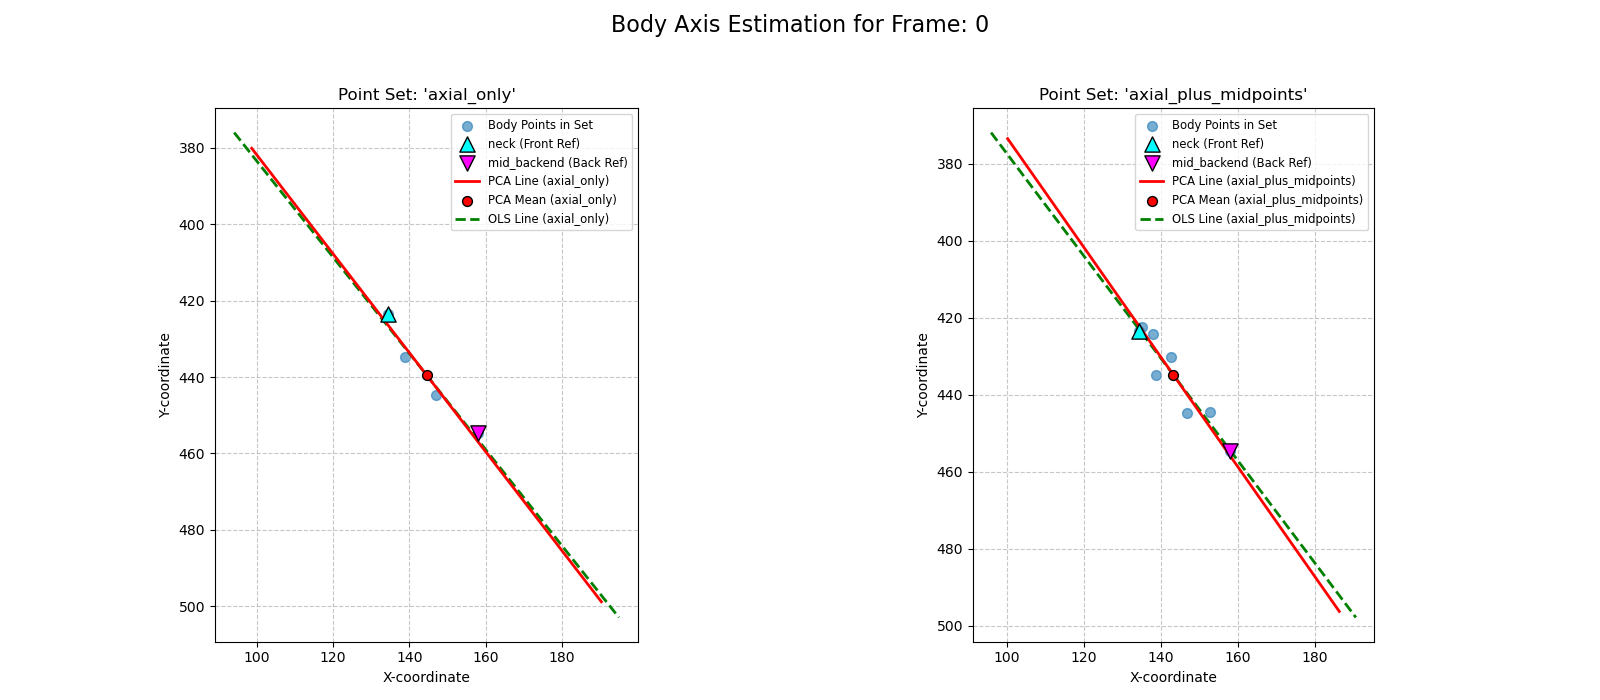

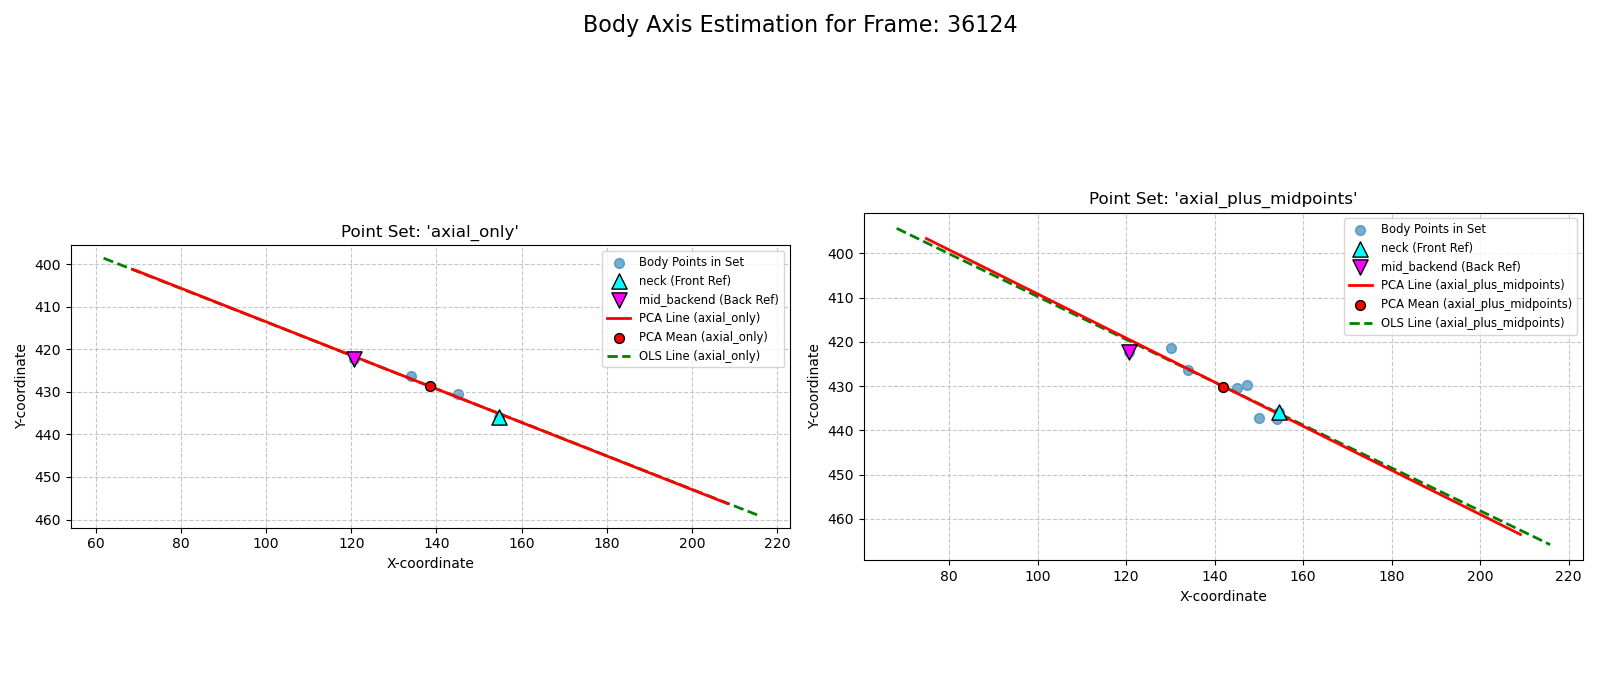

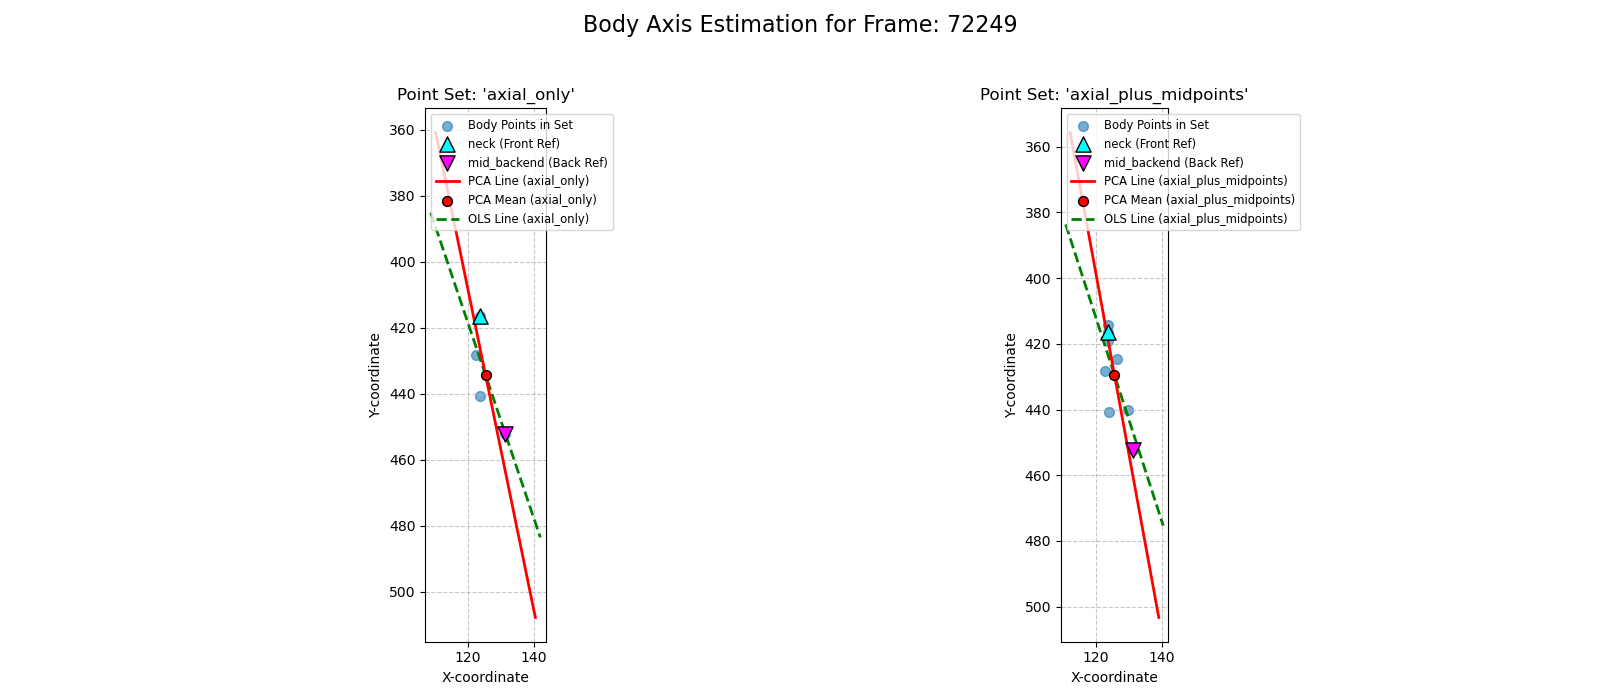

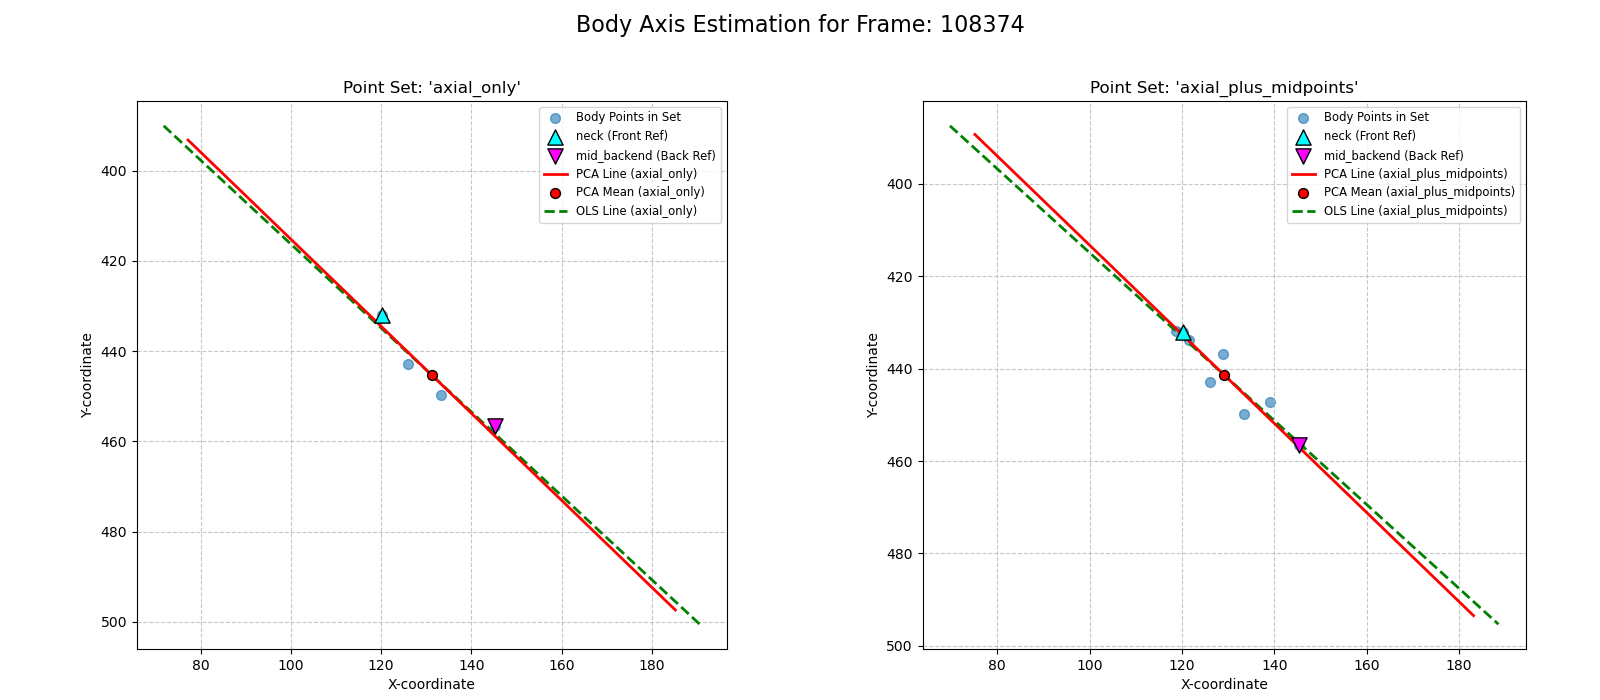

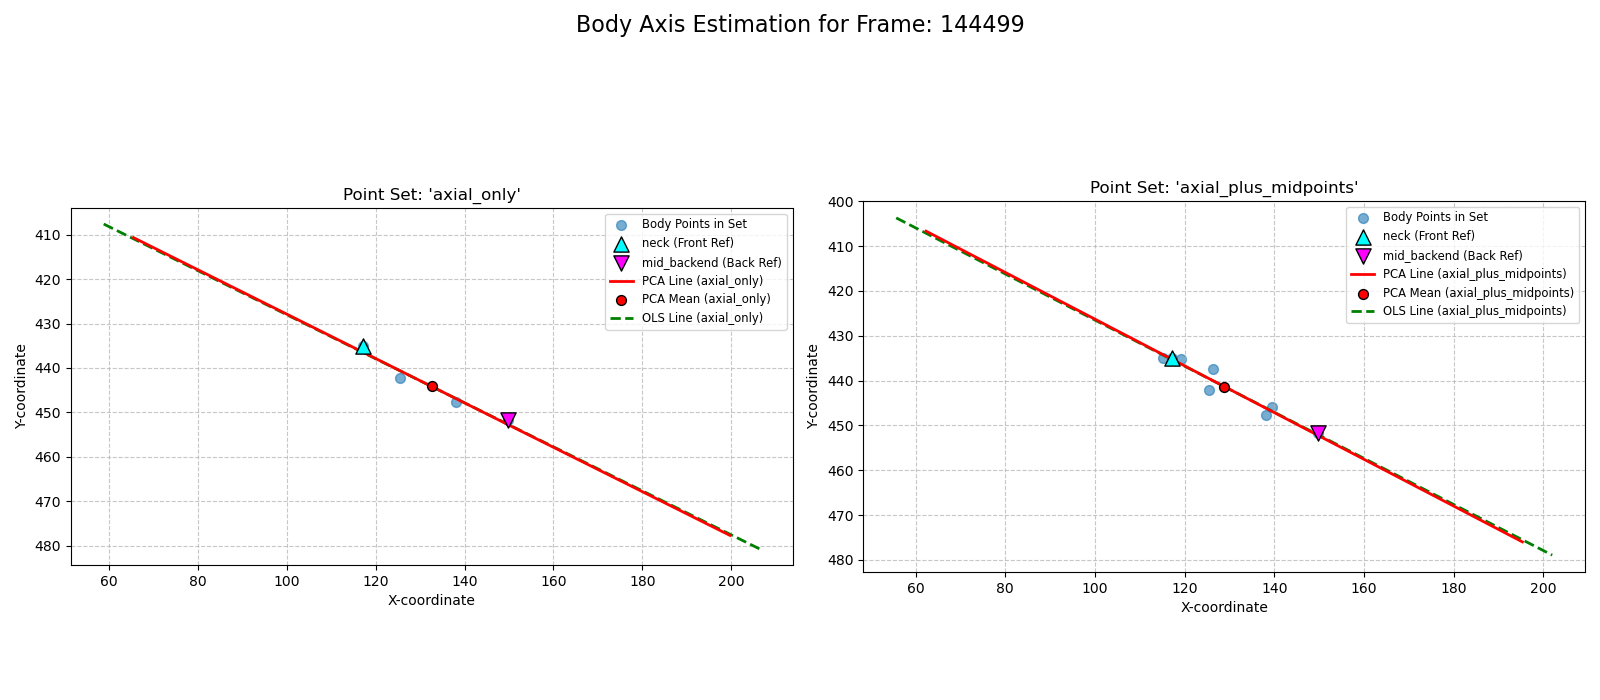

In [17]:
num_sample_frames = 5 # How many sample frames to plot
# Select some frames (e.g., start, middle, end of available frames)
# Ensure these frame indices exist in your df_dlc.index
total_frames = len(df_dlc.index)

# Ensure the raw PCA/OLS dataframes exist
required_dfs = ['df_axial_pca_raw', 'df_axial_ols_raw', 'df_midpoints_pca_raw', 'df_midpoints_ols_raw', 'bodypart_coordinate_sets', 'df_dlc']
for req_df_name in required_dfs:
    if req_df_name not in globals():
        raise NameError(f"Required DataFrame '{req_df_name}' not found. Please ensure previous cells have been run.")

if total_frames == 0:
    print("Error: df_dlc has no frames. Cannot plot sample frames.")
else:
    sample_frame_indices = np.linspace(0, total_frames - 1, num_sample_frames, dtype=int)
    sample_frames = [df_dlc.index[i] for i in sample_frame_indices]

    print(f"\n--- Plotting Body Part Sets with PCA and OLS Lines for Sample Frames: {sample_frames} ---")

    ref_point_front_name = 'neck'
    ref_point_back_name = 'mid_backend'

    for frame_idx in sample_frames:
        fig, axes = plt.subplots(1, 2, figsize=(16, 7)) # Increased figsize for better legend visibility
        fig.suptitle(f"Body Axis Estimation for Frame: {frame_idx}", fontsize=16)

        plot_idx = 0
        for set_name, coords_dfs in bodypart_coordinate_sets.items():
            ax = axes[plot_idx]
            current_x_df = coords_dfs['x']
            current_y_df = coords_dfs['y']

            ax.set_title(f"Point Set: '{set_name}'")
            ax.set_xlabel("X-coordinate")
            ax.set_ylabel("Y-coordinate")
            ax.invert_yaxis() 
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True, linestyle='--', alpha=0.7)

            if frame_idx not in current_x_df.index or frame_idx not in current_y_df.index:
                ax.text(0.5, 0.5, "Frame data not in index", ha='center', va='center')
                plot_idx += 1
                continue

            x_coords_frame_series = current_x_df.loc[frame_idx].dropna()
            y_coords_frame_series = current_y_df.loc[frame_idx].dropna()
            
            common_index = x_coords_frame_series.index.intersection(y_coords_frame_series.index)
            x_coords_frame = x_coords_frame_series[common_index]
            y_coords_frame = y_coords_frame_series[common_index]

            if not x_coords_frame.empty:
                ax.scatter(x_coords_frame, y_coords_frame, label='Body Points in Set', alpha=0.6, s=50)

                # Highlight reference points
                if ref_point_front_name in x_coords_frame.index:
                    ax.scatter(x_coords_frame[ref_point_front_name], y_coords_frame[ref_point_front_name],
                               color='cyan', s=120, label=f'{ref_point_front_name} (Front Ref)', edgecolors='black', zorder=5, marker='^')
                if ref_point_back_name in x_coords_frame.index:
                    ax.scatter(x_coords_frame[ref_point_back_name], y_coords_frame[ref_point_back_name],
                               color='magenta', s=120, label=f'{ref_point_back_name} (Back Ref)', edgecolors='black', zorder=5, marker='v')

                # --- Plot PCA Line ---
                if set_name == "axial_only":
                    pca_params = df_axial_pca_raw.loc[frame_idx]
                else: # axial_plus_midpoints
                    pca_params = df_midpoints_pca_raw.loc[frame_idx]

                if not pca_params.isna().any():
                    pca_dx, pca_dy = pca_params['pca_dx'], pca_params['pca_dy']
                    pca_mean_x, pca_mean_y = pca_params['pca_mean_x'], pca_params['pca_mean_y']
                    
                    # Define line segment for PCA
                    line_len = 75 # Visual length of the line segment
                    x_pca = np.array([pca_mean_x - line_len * pca_dx, pca_mean_x + line_len * pca_dx])
                    y_pca = np.array([pca_mean_y - line_len * pca_dy, pca_mean_y + line_len * pca_dy])
                    ax.plot(x_pca, y_pca, color='red', linestyle='-', linewidth=2, label=f'PCA Line ({set_name})', zorder=3)
                    ax.scatter(pca_mean_x, pca_mean_y, color='red', s=50, edgecolor='black', zorder=4, label=f'PCA Mean ({set_name})')


                # --- Plot OLS Line ---
                if set_name == "axial_only":
                    ols_params = df_axial_ols_raw.loc[frame_idx]
                else: # axial_plus_midpoints
                    ols_params = df_midpoints_ols_raw.loc[frame_idx]

                if not ols_params.isna().any():
                    ols_slope, ols_intercept = ols_params['ols_slope'], ols_params['ols_intercept']
                    
                    # Define x-range for OLS line (use axis limits if available, else data range)
                    xlim = ax.get_xlim() if ax.lines or ax.collections else (x_coords_frame.min(), x_coords_frame.max())
                    if xlim[0] == xlim[1] : # if all x are same, make a small range
                        xlim = (xlim[0] -10, xlim[0]+10)

                    x_ols = np.array(xlim) # Use current x-axis limits for plotting OLS line across the view
                    y_ols = ols_slope * x_ols + ols_intercept
                    ax.plot(x_ols, y_ols, color='green', linestyle='--', linewidth=2, label=f'OLS Line ({set_name})', zorder=2)

            else:
                ax.text(0.5, 0.5, "No valid points for this frame", ha='center', va='center')
            
            ax.legend(fontsize='small')
            plot_idx += 1
        
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout
        plt.show()

if total_frames == 0:
     print("Plotting skipped as df_dlc is empty.")

# Debugging


### Debugging for the median 

Plot X Y trajectories for all selected body parts to see how stable they are over time. 


--- Generating X-Y Trajectory Plots ---


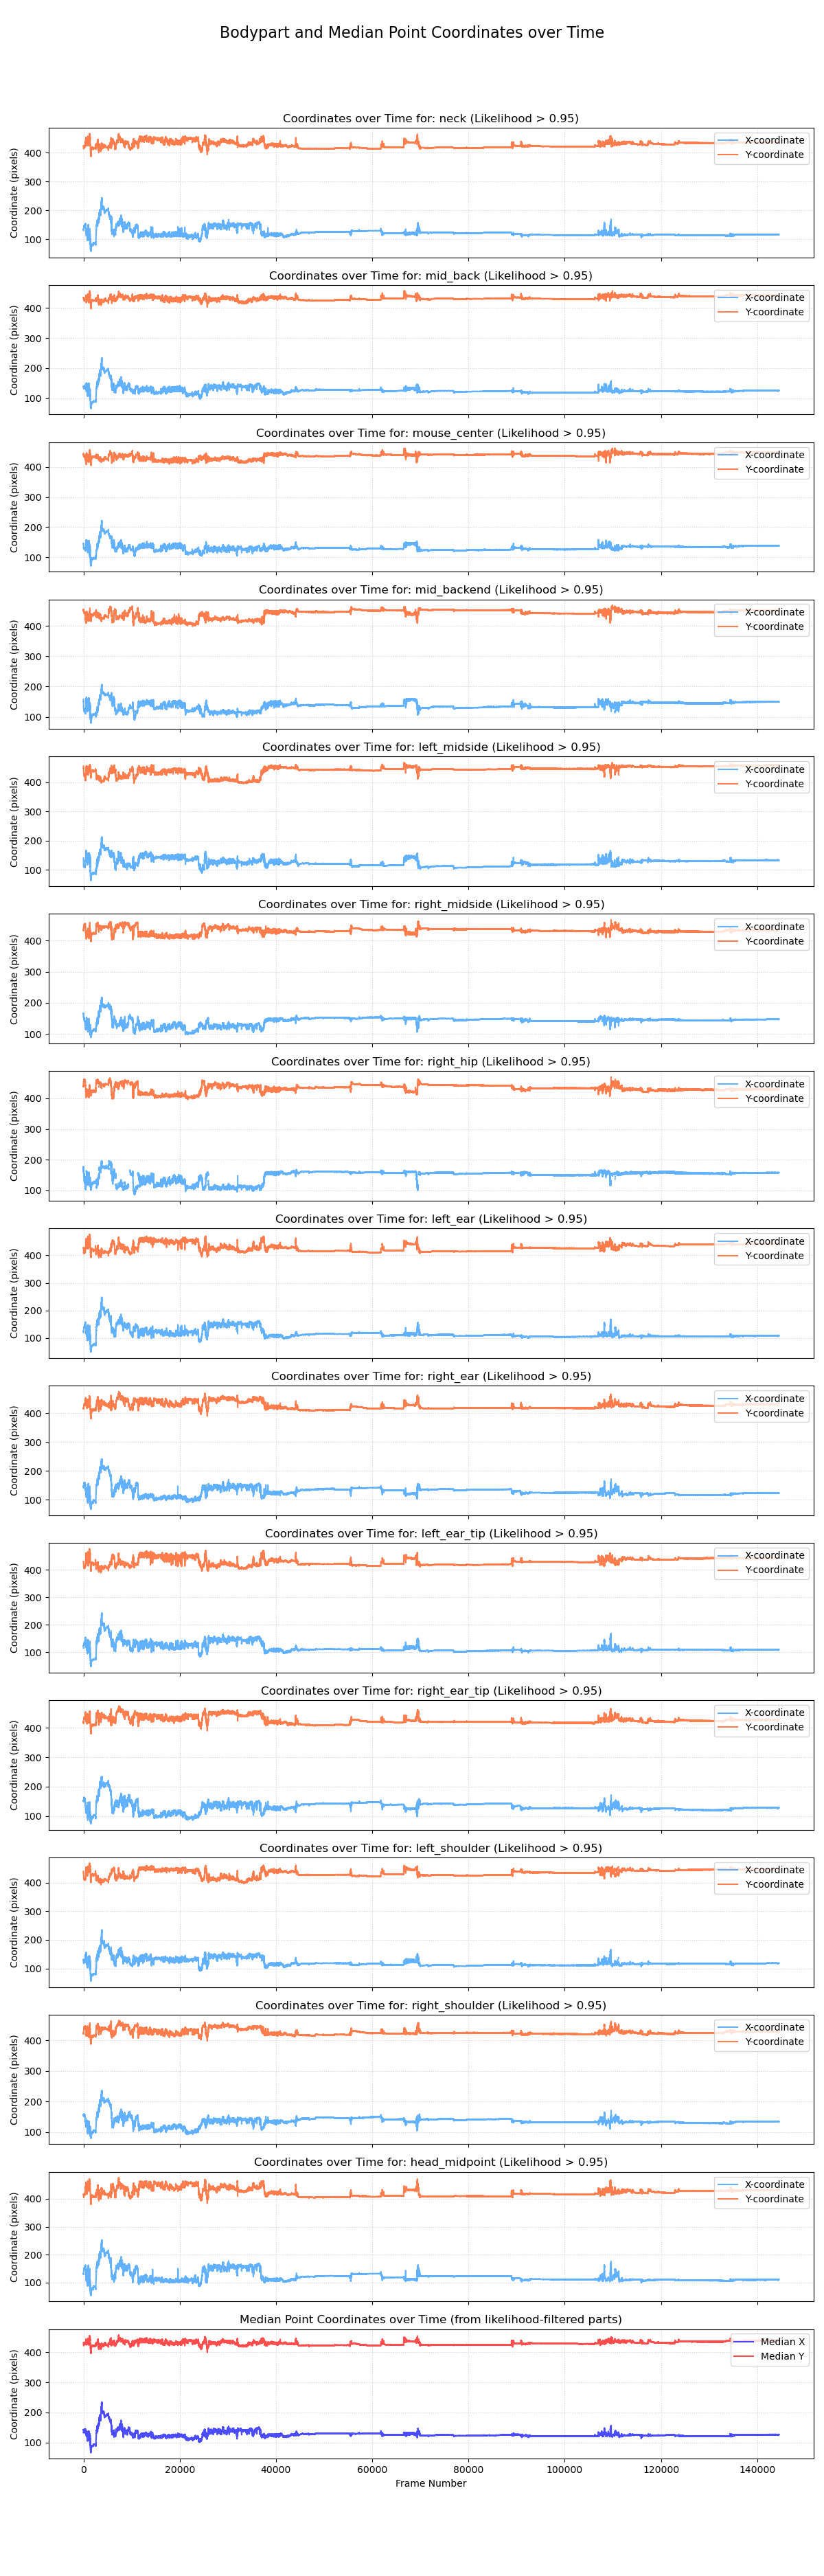

In [7]:
if 'create_plots' in globals() and create_plots:
    if all(var in globals() for var in ['df_dlc', 'final_bodyparts_list', 'likelihood_threshold', 'output_dir_path', 'base_output_name', 'save_plots']):
        print("\n--- Generating X-Y Trajectory Plots ---")
        plot_bodypart_and_median_trajectories(
            df_dlc=df_dlc,
            final_bodyparts_list=final_bodyparts_list,
            likelihood_threshold=likelihood_threshold,
            output_dir_path=output_dir_path,
            plot_file_base_name=base_output_name, 
            save_plot=False,
            display_plot=True # Show plot in notebook
        )
    else:
        print("\nSkipping X-Y trajectory plot: One or more required variables are not defined.")
        print("Required: df_dlc, final_bodyparts_list, likelihood_threshold, output_dir_path, base_output_name, save_plots")
else:
    print("\nSkipping X-Y trajectory plot: 'create_plots' is False or not defined.")


### Debugging: Plot Histogramm of consecutive NaNs in any bodypart after likelihood threshold filtering


--- Generating Consecutive NaN Length Plots ---

NaN sequence lengths plot saved to: C:\Users\Experiment\Projects\video_conversions\full\speed_calculation\fullDLC_resnet50_downsampled_trialJul11shuffle1_150000_default_avg_speed_nan_sequence_lengths.png


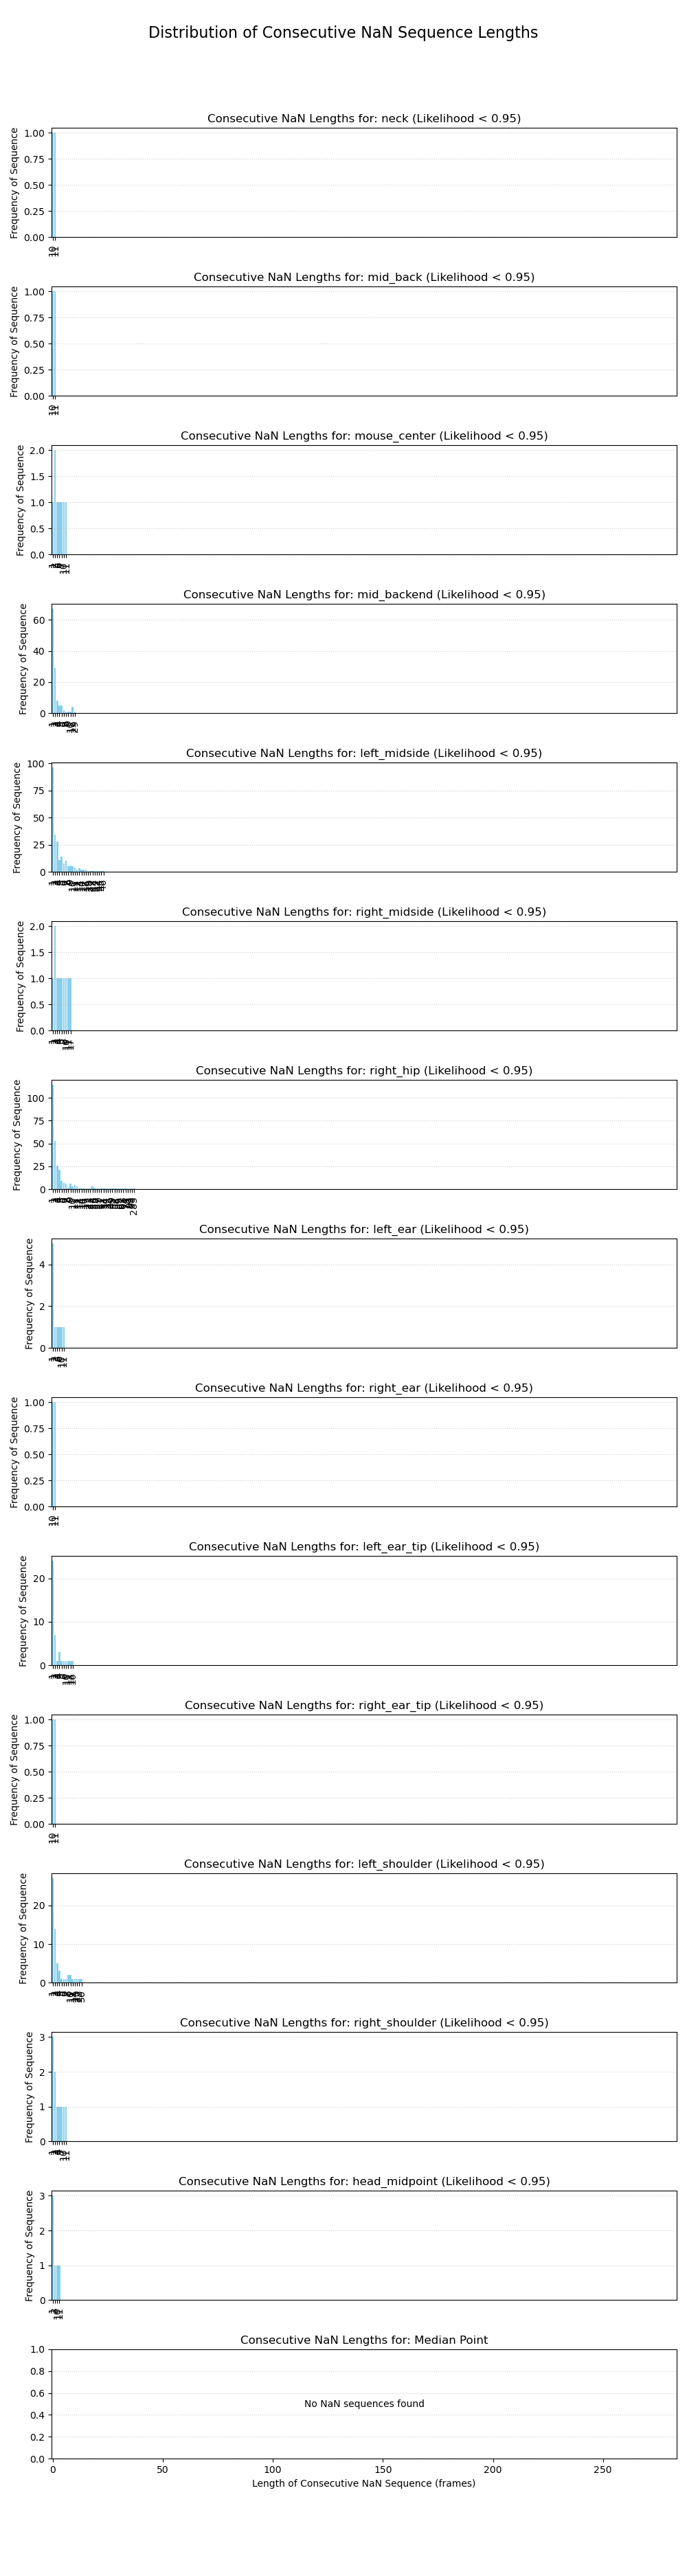

In [8]:
if 'create_plots' in globals() and globals().get('create_plots'):
    if all(var in globals() for var in ['df_dlc', 'final_bodyparts_list', 'likelihood_threshold', 'output_dir_path', 'base_output_name', 'save_plots']):
        print("\n--- Generating Consecutive NaN Length Plots ---")
        plot_consecutive_nan_lengths(
            df_dlc=df_dlc,
            final_bodyparts_list=final_bodyparts_list,
            likelihood_threshold=likelihood_threshold,
            output_dir_path=output_dir_path,
            plot_file_base_name=base_output_name,
            save_plot=globals().get('save_plots', False), # Use globals().get for safety
            display_plot=True
        )
    else:
        print("\nSkipping Consecutive NaN Length Plots: One or more required variables are not defined in globals().")
        required_vars_check = ['df_dlc', 'final_bodyparts_list', 'likelihood_threshold', 'output_dir_path', 'base_output_name', 'save_plots']
        for v in required_vars_check:
            if v not in globals():
                print(f"Missing: {v}")
else:
    if 'create_plots' not in globals():
        print("\nSkipping Consecutive NaN Length Plots: 'create_plots' is not defined in globals().")
    elif not globals().get('create_plots'):
        print("\nSkipping Consecutive NaN Length Plots: 'create_plots' is False.")
